<a href="https://colab.research.google.com/github/agustinivandinocco-python/pythonpracticateoria/blob/main/Colab/clase_06_practica_adicional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio integrador

- Descargar todos los tickers del sp500 de la wikipedia
- Descargar los historicos de precios de esos tickers de yfinance de 2025 en adelante
- Armar un dataframe con la volatilidad diraria de los retornos, el skew y la kurtosis, y el sector e industria de cada uno de los 500 activos
- Graficar un agregado de columnas de kurtosis, skew y volatilidad por sector que incluya la mediana y los percentiles 40 y 60 de cada variable para cada sector
- Graficar los siguientes scatters sobre los deciles de:
  - volatilidad vs kurtosis
  - volatilidad vs skew
  - skew vs kurtosis
  Pintar de diferentes colores segun sector
- Graficar superpuestos KDE de los PDF de volatilidades de cada sector
- Graficar boxplot de volatilidad skew y kurtosis por sector

- Que conclusiones diferentes obtienes de cada grafico?

# Descarga de datos

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.index = [x.replace('.','-') for x in sp500.Symbol]
sp500_tickers = list(sp500.Symbol)

In [ ]:
GICs = sp500.loc[: ,['Symbol','GICS Sector', 'GICS Sub-Industry']]
GICs

,Symbol,GICS Sector,GICS Sub-Industry
MMM,MMM,Industrials,Industrial Conglomerates
AOS,AOS,Industrials,Building Products
ABT,ABT,Health Care,Health Care Equipment
ABBV,ABBV,Health Care,Biotechnology
ACN,ACN,Information Technology,IT Consulting & Other Services
...,...,...,...
XYL,XYL,Industrials,Industrial Machinery & Supplies & Components
YUM,YUM,Consumer Discretionary,Restaurants
ZBRA,ZBRA,Information Technology,Electronic Equipment & Instruments
ZBH,ZBH,Health Care,Health Care Equipment


In [ ]:
%%time

tickers = sp500_tickers
closes = yf.download(tickers, start='2025-01-01')['Close']

[*********************100%***********************]  503 of 503 completed


CPU times: user 21.6 s, sys: 1.83 s, total: 23.4 s
Wall time: 45 s


In [ ]:
lin_ret = closes.pct_change()
volatility = lin_ret.std() * 250**0.5
skewness = lin_ret.skew()
kurtosis = lin_ret.kurt().clip(0,20)
df = pd.concat([volatility, skewness, kurtosis, GICs['GICS Sector'], GICs['GICS Sub-Industry']], axis=1, keys=['volatility', 'skewness', 'kurtosis', 'Sector', 'Industry'])
df

,volatility,skewness,kurtosis,Sector,Industry
A,0.369748,0.294066,2.756989,Health Care,Life Sciences Tools & Services
AAPL,0.454345,1.155053,9.294330,Information Technology,"Technology Hardware, Storage & Peripherals"
ABBV,0.315724,-0.922955,2.388712,Health Care,Biotechnology
ABNB,0.518137,1.498915,7.334010,Consumer Discretionary,"Hotels, Resorts & Cruise Lines"
ABT,0.248546,-0.168963,1.778911,Health Care,Health Care Equipment
...,...,...,...,...,...
XYL,0.296090,-0.001169,4.350112,Industrials,Industrial Machinery & Supplies & Components
YUM,0.294246,0.410457,11.229728,Consumer Discretionary,Restaurants
ZBH,0.320010,-2.365658,11.143719,Health Care,Health Care Equipment
ZBRA,0.569976,-0.187579,8.271409,Information Technology,Electronic Equipment & Instruments


# Graficos

In [ ]:
aggs = df.groupby('Sector')[['volatility', 'skewness', 'kurtosis']].mean()
aggs

,volatility,skewness,kurtosis
Sector,,,
Communication Services,0.368291,-0.131199,6.053051
Consumer Discretionary,0.420098,0.224876,5.088978
Consumer Staples,0.303236,-0.140497,3.291975
Energy,0.437431,-0.934166,5.542666
Financials,0.355308,-0.510845,6.070495
Health Care,0.380858,-0.361178,5.201764
Industrials,0.375507,-0.000573,5.827181
Information Technology,0.497839,0.168926,6.655448
Materials,0.379468,0.163684,4.462211


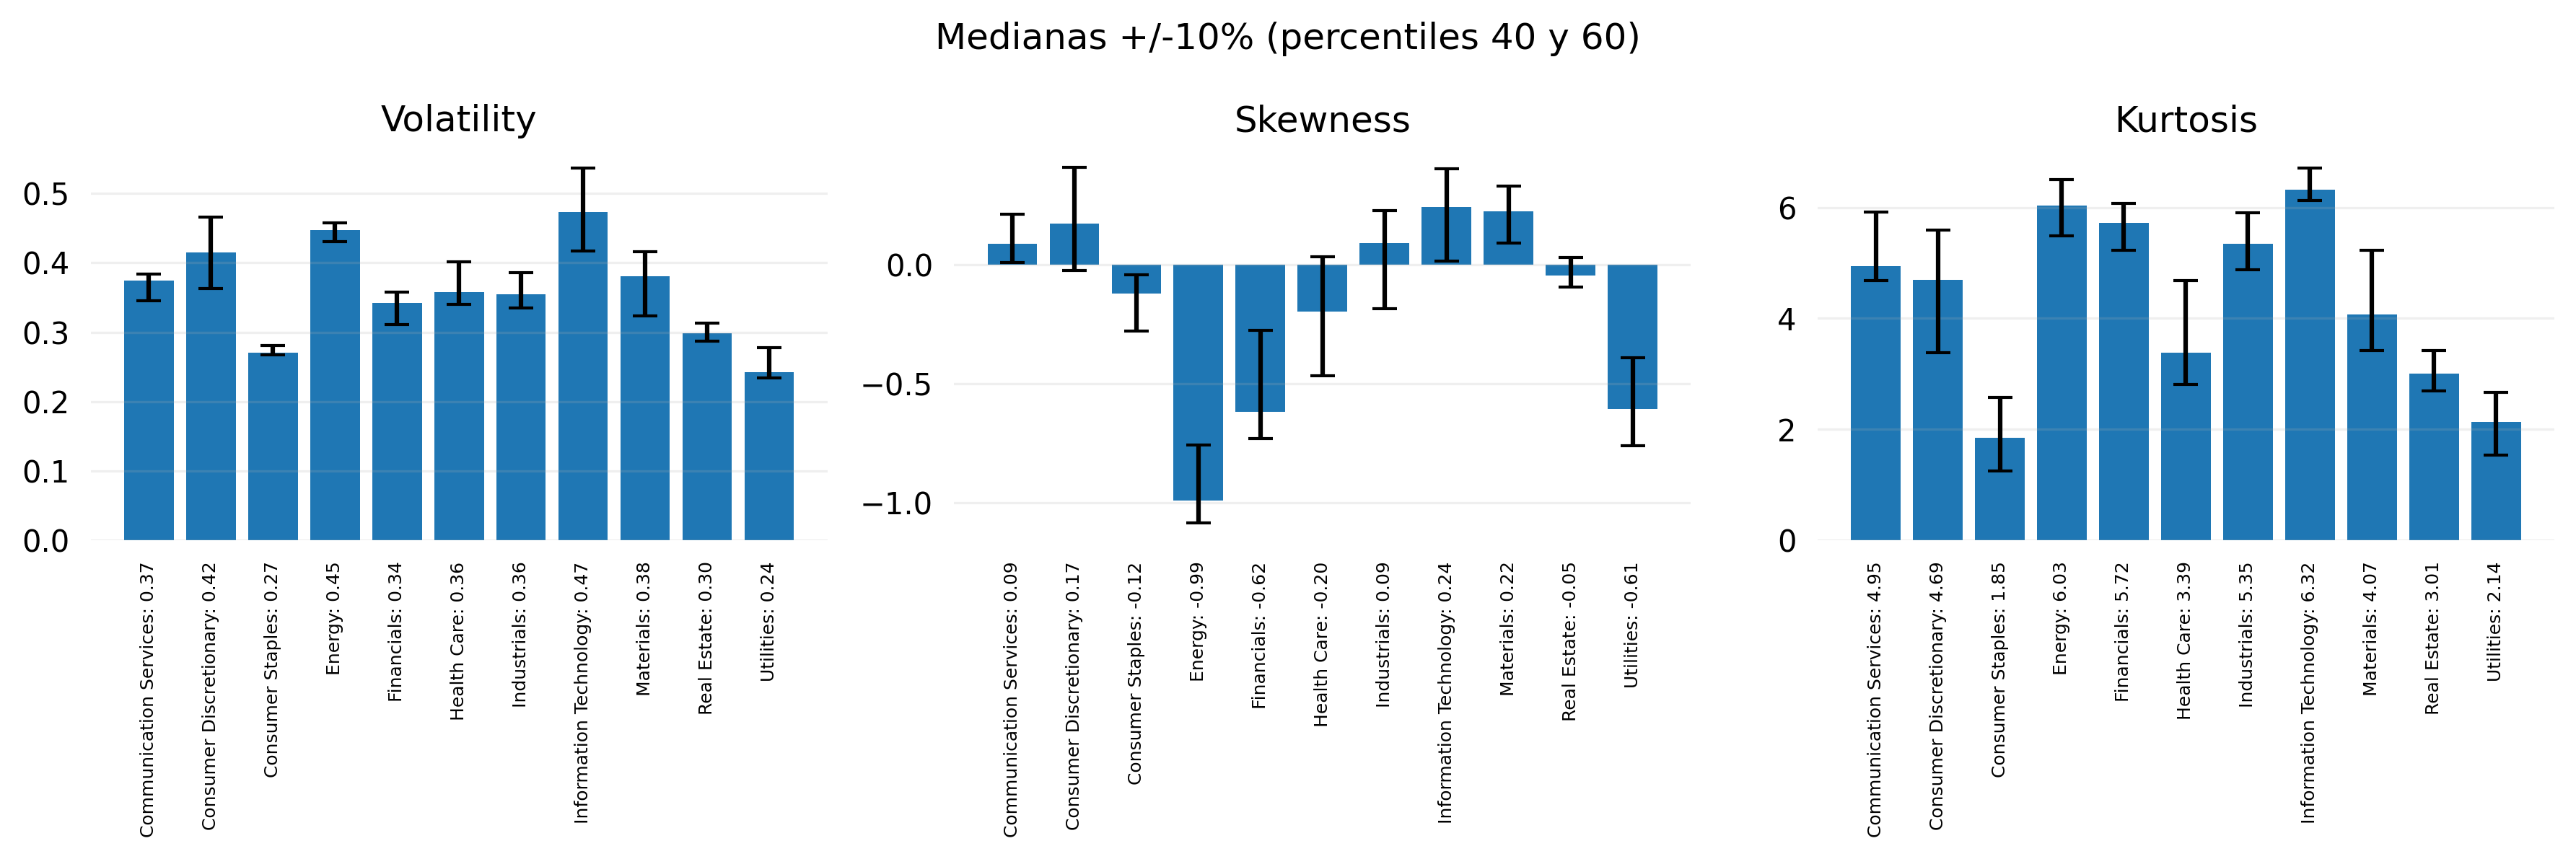

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['volatility', 'skewness', 'kurtosis']
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300)

for i, col in enumerate(cols):
    grouped = df.groupby('Sector')[col]
    medians = grouped.median()
    q10 = grouped.quantile(0.4)
    q90 = grouped.quantile(0.6)

    sectors = medians.index
    x = range(len(sectors))
    y = medians.values
    yerr_lower = medians - q10
    yerr_upper = q90 - medians

    ax[i].bar(x, y, yerr=[yerr_lower, yerr_upper], capsize=4, color='C0')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels([f"{s}: {v:.2f}" for s, v in zip(sectors, y)], rotation=90, fontsize=6)
    ax[i].set_title(col.capitalize())
    ax[i].spines[['top', 'right', 'left', 'bottom']].set_visible(False)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].grid(True, axis='y', alpha=0.2)

plt.suptitle('Medianas +/-10% (percentiles 40 y 60)')
plt.tight_layout()
plt.show()

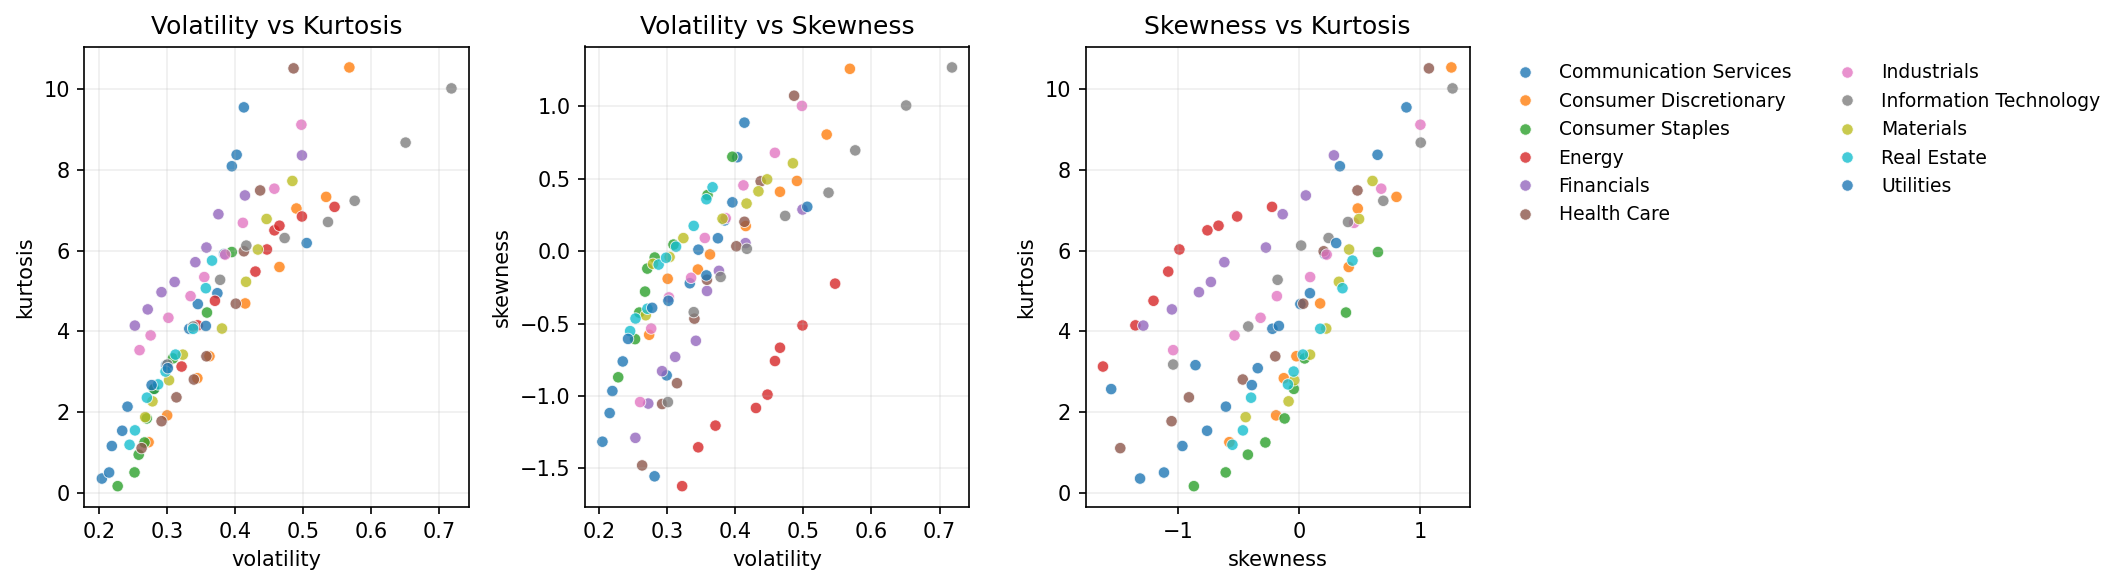

In [ ]:
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
res = []

for sector, group in df.groupby('Sector'):
    numeric = group[['volatility', 'kurtosis', 'skewness']]
    for quant in q:
        row = numeric.quantile(quant)
        res.append({
            'Sector': sector,
            'quantile': quant,
            'volatility': row['volatility'],
            'kurtosis': row['kurtosis'],
            'skewness': row['skewness']
        })

deciles_df = pd.DataFrame(res)

fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

pairs = [
    ('volatility', 'kurtosis'),
    ('volatility', 'skewness'),
    ('skewness', 'kurtosis')
]

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(data=deciles_df, x=x, y=y, hue='Sector', palette='tab10', s=30, alpha=0.8, ax=ax[i])
    ax[i].set_title(f'{x.capitalize()} vs {y.capitalize()}')
    ax[i].legend().remove()
    ax[i].grid(True, alpha=0.2)

plt.tight_layout()
plt.legend(frameon=False, ncols=2, fontsize=9, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

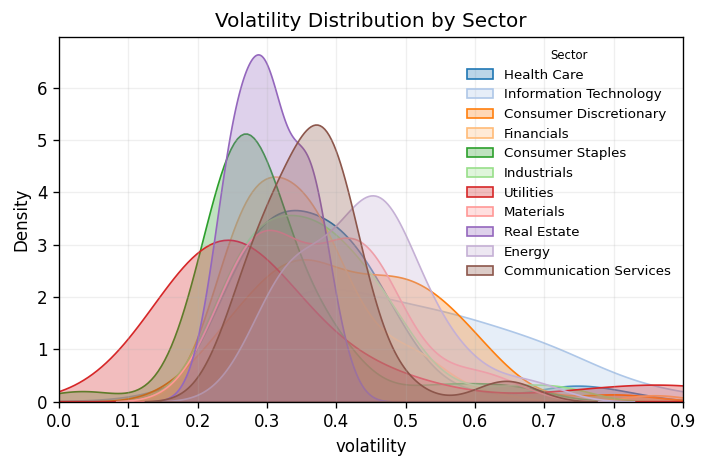

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sectors = df['Sector'].unique()
pal = sns.color_palette('tab20', len(sectors))
fig, ax = plt.subplots(figsize=(6,4), dpi=120)
for s, c in zip(sectors, pal):
    sns.kdeplot(df.loc[df['Sector']==s, 'volatility'], label=s, color=c, common_norm=False, fill=True, alpha=0.3, ax=ax)
ax.set_title('Volatility Distribution by Sector')
ax.grid(True, alpha=0.2)
ax.legend(frameon=False, title='Sector', fontsize=8, title_fontsize=7)
ax.set_xlim(0, 0.9)
plt.tight_layout()
plt.show()

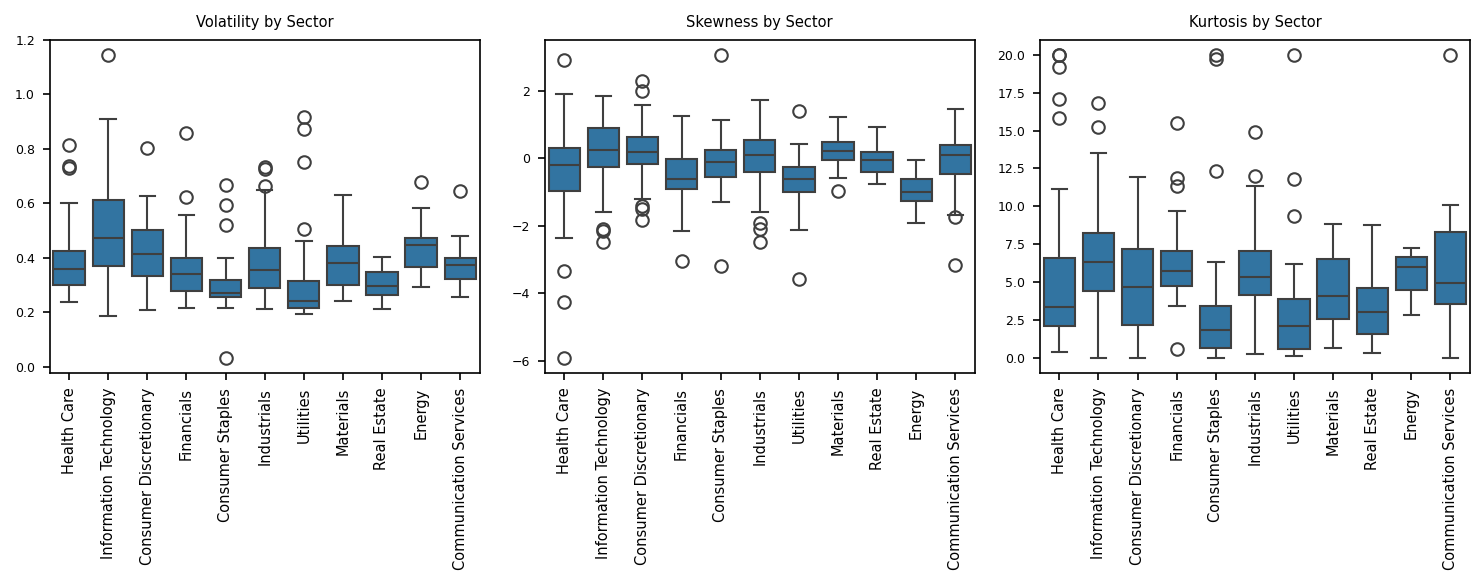

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

sns.boxplot(data=df, x='Sector', y='volatility', ax=ax[0])
ax[0].set_title('Volatility by Sector')
ax[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=df, x='Sector', y='skewness', ax=ax[1])
ax[1].set_title('Skewness by Sector')
ax[1].tick_params(axis='x', rotation=90)

sns.boxplot(data=df, x='Sector', y='kurtosis', ax=ax[2])
ax[2].set_title('Kurtosis by Sector')
ax[2].tick_params(axis='x', rotation=90)

for a in ax:
    a.set_xlabel('')
    a.set_ylabel('')
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=6)
    a.title.set_fontsize(7)

plt.tight_layout()
plt.show()